In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import tensorflow as tf
tf.__version__

'1.13.0-rc2'

## Load the data

In [8]:
main_dir = '/home/yulia/W266-Final-Project/'

In [9]:
data_path = main_dir+'data/raw/hein-daily'

In [10]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [11]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [12]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt')
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 22.8 seconds to create the dictionary


In [13]:
len(list(descr.keys()))/2914464

0.9634876258550458

In [14]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

## Data QA

In [18]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2579578
2,1,228472


Target group number of speeches by party:
A: 	 0
D: 	 165834
I: 	 0
N: 	 0
NA: 	 -1058151
P: 	 0
R: 	 62638

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2566825
2,1,241225


Target group number of speeches by party:
A: 	 21
D: 	 213500
I: 	 64
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 27253

 Age
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,1836698
2,1,971352


Target group number of speeches by party:
A: 	 21
D: 	 482630
I: 	 360
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 487954


In [21]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
date 20101116
char_count 517
word_count 93
speakerid 111120680.0
Party D
Congress 111
Chamber H
State DC
Ethnicity B
Age 73.0
Age_lt_med 0.0
NonWhite 1.0
Female 1.0
speaker Ms. NORTON
Full Name NORTON, ELEANOR
match exact
check 1

Mr. Speaker. may I also indicate that this bill gives the public defender of the District of Columbia the right to purchase liability insurance. a right that the Federal public defenders have throughout the United States. The reason the bill is necessary in order to give them this right is that the public defender of the District of Columbia exists in a twilight zone. as it were. It handles local matters. but it is a Federal agency. So we need the imprimatur of this Congress. I yield back the balance of my time.


# Ethnicity Model

## Split into train, validate, test

In [22]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, ethnicity, descr)

Training split: 94260 ones and 94260 zeroes
Training speech list size: 188520
Training target list size: 188520
Validation split: 31420 ones and 31420 zeroes
Validation speech list size: 62840
Validation target list size: 62840
Test split: 31420 ones and 31420 zeroes
Test speech list size: 62840
Test target list size: 62840


In [23]:
sum(train_target), sum(val_target), sum(test_target)

(94260, 31420, 31420)

In [24]:
# number of speeches under 30 words
sum(np.array(ethnicity)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

84125

In [25]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 20120801
char_count 955
word_count 158
speakerid 112116580.0
Party D
Congress 112
Chamber H
State CA
Ethnicity H
Age 65.0
Age_lt_med 0.0
NonWhite 1.0
Female 0.0
speaker Mr. BACA
Full Name BACA, JOE
match exact
check 1

Madam Speaker. this Monday. Colton Joint Unified School District held a dedication ceremony for the new Joe Baca Middle School in Bloomington. California. Next week. 800 students from the surrounding communities in Bloomington and Rialto will begin to attend classes there. I am truly humbled to receive this distinguished honor. and I thank the Colton Joint Unified School District. I want to especially recognize Superintendent Jerry Almendarez. all of the school board members of the Colton Joint Unified School District. Ignacio Gomez. whose beautiful artwork will be displayed at the school. and Congressman GARY MILLER for his bipartisan support. Growing up the youngest of 15 children in a poor household. I never would imagine that one day I would 

In [26]:
del all_speeches, all_speech_ids, descr

## EDA on train data

In [27]:
explore_data.get_num_words_per_sample(train)

238.0

In [28]:
explore_data.get_num_words_per_sample(val)

238.0

In [29]:
explore_data.get_num_words_per_sample(test)

238.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  45.0  74.0  126.0  181.0  238.0  312.0  402.0  540.0  805.0  22613.0


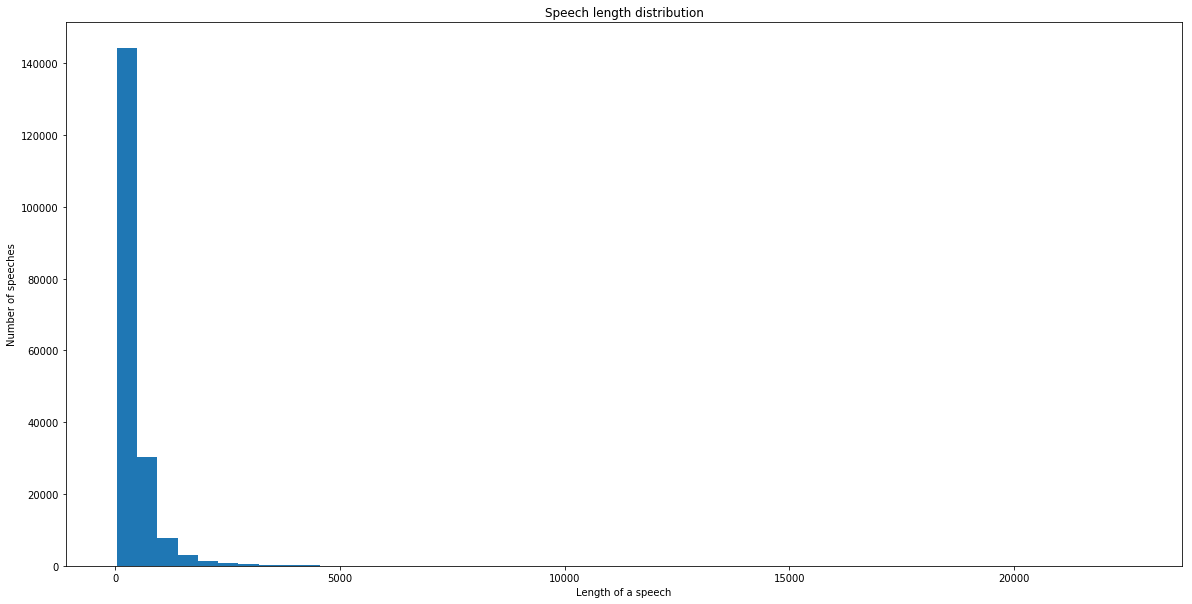

In [30]:
explore_data.plot_sample_length_distribution(train)

## CNN Models

### Pre-processing

In [31]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [32]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 157.2 seconds to tokenize the data


In [33]:
len(train), len(val), len(test)

(188520, 62840, 62840)

In [34]:
len(train_vec), len(val_vec), len(test_vec)

(188520, 62840, 62840)

In [35]:
max(map(max, train_vec)), max(map(max, val_vec)), max(map(max, test_vec))

(19999, 19999, 19999)

In [36]:
len(word_index)

474232

In [37]:
train_vec[0].shape

(750,)

In [38]:
train[0]

'Mr. Speaker. I rise today to honor Thomas A. Kelley. an extraordinary constituent of Californias 18th Congressional District who has been chosen to receive the STAR Award by AchieveKids on June 20. 2015. in Palo Alto. California. Tom Kelley is a 1962 graduate of Rice University where he earned both B.A. and B.S. degrees. and a 1967 graduate of the Stanford Business School. He founded Thomas A. Kelley & Associates. an executive search firm in 1969. on Sand Hill Road in Menlo Park. California. The companys mission was to bring together management teams for high technology startups. While performing executive searches. Thomas A. Kelley & Associates invested in prepublic client companies and achieved financial success. While managing the evergrowing business. Tom continued to personally conduct searches through the life of the company. In 2002. the company became Thomas A. Kelley Investments. which manages the Kelley Family Trust and performs pro bono consulting for tech entrepreneurs. In

In [39]:
train_vec[0][-10:]

array([   3,   16,   41, 3089,    5,    7,    4,   41, 1405,  231],
      dtype=int32)

In [40]:
for word in train[0].split()[-10:]:
    word = re.sub(r'[^\w\s]','',word)
    print(word, word_index[word])

to 3
have 16
his 41
friendship 3089
and 5
that 7
of 4
his 41
extraordinary 1405
family 231


### Saving processed files

In [43]:
token_path = main_dir+'Classification/data/tokenized/ethnicity'

In [44]:
np.save(os.path.join(token_path, 'train_vec'), train_vec)
np.save(os.path.join(token_path, 'val_vec'), val_vec)
np.save(os.path.join(token_path, 'test_vec'), test_vec)

In [45]:
pickle.dump(word_index, open(os.path.join(token_path, 'word_index.p'), 'wb'))

In [ ]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [ ]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [ ]:
len(train_vec), len(val_vec), len(test_vec)

## CNN model - Full Speech + Glove Embeddings

In [46]:
logs_base_dir = main_dir + 'Classification/logs'

In [47]:
cnn_model_params = {
    'model': 'cnn',
    'word_index': word_index,
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 5,
    'pool_size': 1,
    'max_num_words': 20000,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': main_dir + 'data'
}

In [48]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 20.0 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 188520 samples, validate on 62840 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
 - 1244s - loss: 0.6051 - acc: 0.6663 - val_loss: 0.5569 - val_acc: 0.7117
Epoch 2/1000
 - 1249s - loss: 0.5499 - acc: 0.7173 - val_loss: 0.5457 - val_acc: 0.7266
Epoch 3/1000
 - 1322s - loss: 0.5246 - acc: 0.7372 - val_loss: 0.5316 - val_acc: 0.7338
Epoch 4/1000
 - 1359s - loss: 0.5020 - acc: 0.7542 - val_loss: 0.5260 - val_acc: 0.7342
Epoch 5/1000
 - 1268s - loss: 0.4799 - acc: 0.7680 - val_loss: 0.5262 - val_acc: 0.7347
Epoch 6/1000
 - 1294s - loss: 0.4584 - a

### Clean up space/save outputs

In [49]:
probs_path = main_dir+'Classification/data/probs/ethnicity/'

In [50]:
np.save(probs_path+'val_pred_probs_cnn', val_pred_probs, allow_pickle=True, fix_imports=True)

In [ ]:
val_pred_probs = np.load(probs_path+'val_pred_probs_cnn.npy', allow_pickle=True, fix_imports=True)

## Model Evaluation

In [51]:
val_preds = val_pred_probs > 0.5
np.mean(val_preds.flatten()==val_target)

0.7338796944621261

In [52]:
val_preds.shape, len(val_target)

((62840, 1), 62840)

In [95]:
sum(val_preds)

array([30823])

Confusion matrix, without normalization
[[23357  8063]
 [ 8660 22760]]
             precision    recall  f1-score   support

      White       0.73      0.74      0.74     31420
   NonWhite       0.74      0.72      0.73     31420

avg / total       0.73      0.73      0.73     62840



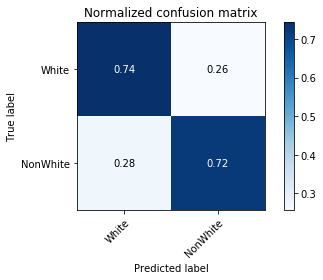

In [105]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['White', 'NonWhite']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

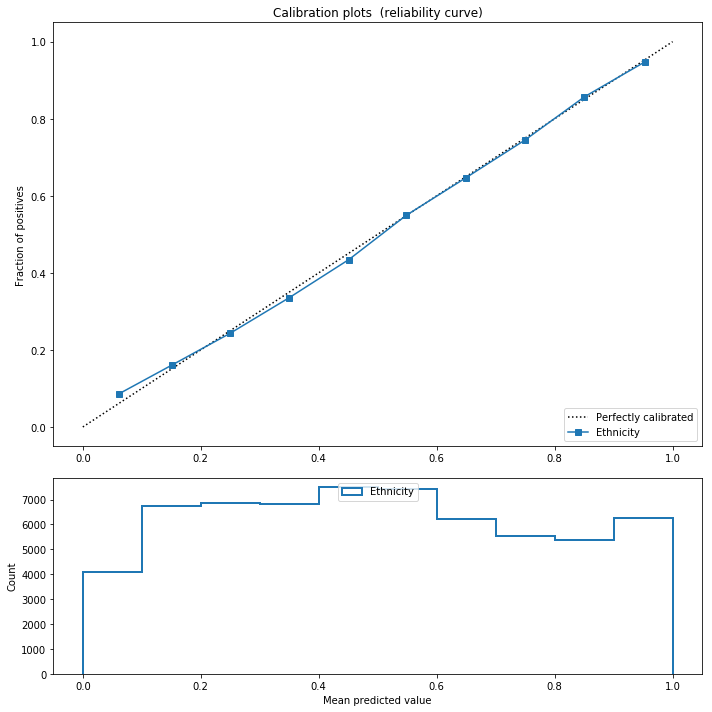

In [55]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Ethnicity')

In [58]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62840, 16)

In [59]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.175939            0.5  58.427562  0.690738   0.694876    376.978469


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.45,0.44,1.00,0.79,0.62,1.10
0.6,0.88,0.98,0.99,0.99,1.17,0.82
1.0,1.65,1.60,1.01,1.23,1.29,1.01


In [60]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
mr president 	 2728.7
speaker 	 1945.4
senator 	 1896.6
mr speaker 	 1740.6
speaker rise 	 1564.9
the senator 	 1531.4
senator from 	 1474.0
rise 	 1187.0
president 	 1179.9
rise today 	 715.0


bin,1,2,3
mr president,18121.0,2792.0,2832.0
mr speaker,10195.0,11114.0,26170.0
president,33463.0,8758.0,12879.0
rise,4485.0,2973.0,9004.0
rise today,1871.0,1076.0,4068.0
senator,20370.0,2584.0,2679.0
senator from,7043.0,475.0,341.0
speaker,12021.0,12845.0,30206.0
speaker rise,1373.0,1309.0,5065.0
the senator,7574.0,554.0,285.0


In [61]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.94):

date                 19890607
char_count               1952
word_count                331
speakerid         1.01109e+08
Party                       D
Congress                  101
Chamber                     H
State                      CA
Ethnicity             B/AAPIA
Age                        64
Age_lt_med                  0
NonWhite                    1
Female                      0
speaker           Mr. DYMALLY
Full Name     DYMALLY, MERVYN
match                   exact
Name: 1010032099, dtype: object

 Mr. Chairman. I want to thank the gentleman from New York for bringing this amendment to the floor to those Members who have some concerns about this particular issue with the Japanese Government. and their corporations may have an opportunity to express our concerns. Let me say this: Some people have suggested that those Members who oppose deal are indulging in Japanbashing. I want to establish my credentials. No Member of this Congress has 

## CNN - chunking the data

### Prepare the data

In [62]:
chunk_len=50

In [67]:
reload(preprocess_data)
start_time = time.time()
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)
test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=chunk_len)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

Original data has 188520 speeches
It was split into 1507038 chunks
Checks on ids and target 1507038 1507038
Original target mean 0.5
New target mean 0.49381103860685666
Original data has 62840 speeches
It was split into 503395 chunks
Checks on ids and target 503395 503395
Original target mean 0.5
New target mean 0.4916020222687949
Original data has 62840 speeches
It was split into 507051 chunks
Checks on ids and target 507051 507051
Original target mean 0.5
New target mean 0.49672715367882125

It took 14.1 seconds to create the dictionary


In [65]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = chunk_len

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [68]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train_chunk, val_chunk, test_chunk, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 208.2 seconds to tokenize the data


In [69]:
np.save(os.path.join(token_path, 'train_vec_chunk'), train_vec)
np.save(os.path.join(token_path, 'val_vec_chunk'), val_vec)
np.save(os.path.join(token_path, 'test_vec_chunk'), test_vec)

In [ ]:
train_vec = np.load(os.path.join(token_path, 'train_vec_chunk.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec_chunk.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec_chunk.npy'))

In [70]:
train_vec.shape

(1507038, 50)

In [71]:
train_vec[0]

array([   26,    47,    10,   178,    70,     3,   368,  1699,     8,
       15607,    32,  1405,  3821,     4,  4318,  5759,   295,   207,
          35,    27,    46,  2511,     3,   568,     2,  2572,   810,
          24,     1,    15,   929,   449,  3075,     6, 11791, 11026,
         303,  2488, 15607,     9,     8,  5004,  1995,     4,  5153,
         431,   146,    39,  1314,   195], dtype=int32)

In [72]:
type(train_vec)

numpy.ndarray

### Run the model

In [73]:
history_chunk, train_pred_probs_chunk, val_pred_probs_chunk = train_model.train_model(((train_vec, train_target_chunk), (val_vec, val_target_chunk)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 20.3 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Train on 1507038 samples, validate on 503395 samples
Epoch 1/1000
 - 967s - loss: 0.6170 - acc: 0.6528 - val_loss: 0.6044 - val_acc: 0.6680
Epoch 2/1000
 - 845s - loss: 0.5936 - acc: 0.6768 - val_loss: 0.6028 - val_acc: 0.6677
Epoch 3/1000
 - 870s - loss: 0.5826 - acc: 0.6872 - val_loss: 0.5981 - val_acc: 0.6741
Epoch 4/1000
 - 892s - loss: 0.5723 - acc: 0.6963 - val_loss: 0.5981 - val_acc: 0.6743
Epoch 5/1000
 - 894s - loss: 0.5622 - acc: 0.7044 - val_loss: 0.5981 - val_acc: 0.6743
Validation accuracy: 0.6743054389953613, loss: 0.5980726024649585


In [101]:
np.save(probs_path+'val_pred_probs_cnn_chunk', val_pred_probs_chunk, allow_pickle=True, fix_imports=True)

In [98]:
val_preds_chunk = val_pred_probs_chunk > 0.5
np.mean(val_preds_chunk.flatten()==val_target_chunk)

0.6743054658866298

In [99]:
val_preds_chunk.shape

(503395, 1)

In [100]:
sum(val_preds_chunk)

array([239889])

In [76]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs_chunk.flatten(), 'preds': val_preds_chunk.flatten()})
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1000000470,0.300465,0.517254,0.408860,1,0.500000,0,0
1,1000000543,0.118292,0.421215,0.256245,0,0.000000,0,0
2,1000000888,0.340131,0.882748,0.534214,1,0.333333,1,0
3,1000000889,0.407661,0.934524,0.743561,1,0.750000,1,1
4,1000000904,0.239784,0.827516,0.524707,1,0.666667,1,1


In [77]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean), np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

(0.7440642902609803, 0.7259388924252069)

In [153]:
original_df = pd.DataFrame({'target_orig': val_target, 'ids': val_ids})
original_df = original_df.merge(pred_aggr_df, on="ids")
original_df.head()

,target_orig,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1,1010243717,0.344667,0.602394,0.447245,1,0.250000,0,0
1,1,1120097305,0.542501,0.849781,0.662056,1,1.000000,1,1
2,1,1020183502,0.576263,0.576263,0.576263,1,1.000000,1,1
3,1,1080187463,0.247439,0.763894,0.464190,1,0.555556,0,1
4,1,1090010764,0.221940,0.885637,0.577205,1,0.666667,1,1


In [154]:
original_df.target_orig.sum(), original_df.target.sum()

(31420, 31420)

## Model evaluation

In [158]:
val_pred_aggr_chunk = original_df.preds_probs_mean
val_pred_probs_aggr_chunk = original_df.probs_mean
# val_aggr_target = pred_aggr_df.target
# val_aggr_ids = pred_aggr_df.ids

In [156]:
np.save(probs_path+'val_pred_probs_cnn_aggr_chunk', val_pred_probs_aggr_chunk, allow_pickle=True, fix_imports=True)

Confusion matrix, without normalization
[[23522  7898]
 [ 8185 23235]]
             precision    recall  f1-score   support

      White       0.74      0.75      0.75     31420
   NonWhite       0.75      0.74      0.74     31420

avg / total       0.74      0.74      0.74     62840



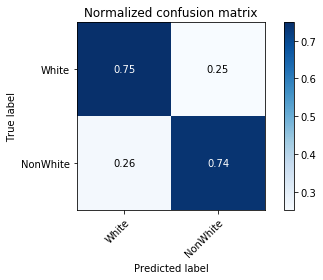

In [159]:
reload(explore_data)
# specify class names in 0 - 1 order
explore_data.plot_confusion_matrix(val_target, val_pred_aggr_chunk, classes, normalize=True)

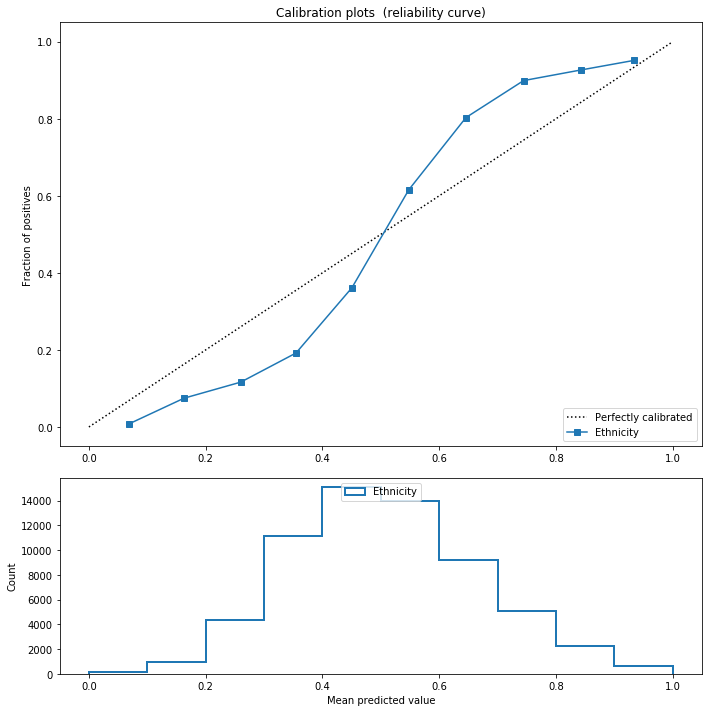

In [81]:
reload(explore_data)
explore_data.plot_calibration_curve(val_aggr_target, val_pred_probs_aggr_chunk, 'Ethnicity')

In [82]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs_aggr_chunk, 
                                   val_aggr_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.175939            0.5  58.427562  0.690738   0.694876    376.978469


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.31,0.33,1.00,0.75,0.48,1.01
0.6,0.91,0.97,0.99,0.99,1.12,1.07
1.0,1.82,1.71,1.01,1.26,1.29,0.87


In [83]:
reload(explore_data)
explore_data.compare_ngrams(val_chunk, val_pred_probs_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
mr president 	 9892.9
speaker 	 7975.7
senator 	 7452.2
mr speaker 	 6829.5
president 	 5185.7
the senator 	 4441.6
black 	 4104.0
senator from 	 4035.8
it 	 3495.7
district 	 3080.6


bin,1,2,3
black,217.0,387.0,5827.0
district,1710.0,3165.0,8818.0
it,80457.0,75612.0,40661.0
mr president,17587.0,3933.0,2012.0
mr speaker,6324.0,16077.0,24704.0
president,29671.0,15604.0,9825.0
senator,20164.0,3761.0,1708.0
senator from,7111.0,503.0,139.0
speaker,7412.0,18814.0,28846.0
the senator,7731.0,474.0,100.0


In [86]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs_aggr_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
those citizens 	 14.1
even tell 	 13.2
recovery from 	 13.1
simply on 	 11.5
other over 	 11.4
find great 	 11.2
fund tax 	 11.1
senseless violence 	 10.7
to arouse 	 10.7
other bills 	 10.6


bin,1,2,3
even tell,11.0,1.0,0.0
find great,8.0,0.0,0.0
fund tax,12.0,1.0,1.0
other bills,9.0,42.0,45.0
other over,11.0,0.0,1.0
recovery from,35.0,14.0,9.0
senseless violence,5.0,7.0,27.0
simply on,2.0,4.0,16.0
those citizens,9.0,7.0,28.0
to arouse,0.0,0.0,8.0


In [91]:
len(val_target), len(val), len(val_ids), val_pred_probs_aggr_chunk.shape

(62840, 62840, 62840, (62840,))